TypeError: list indices must be integers or slices, not tuple

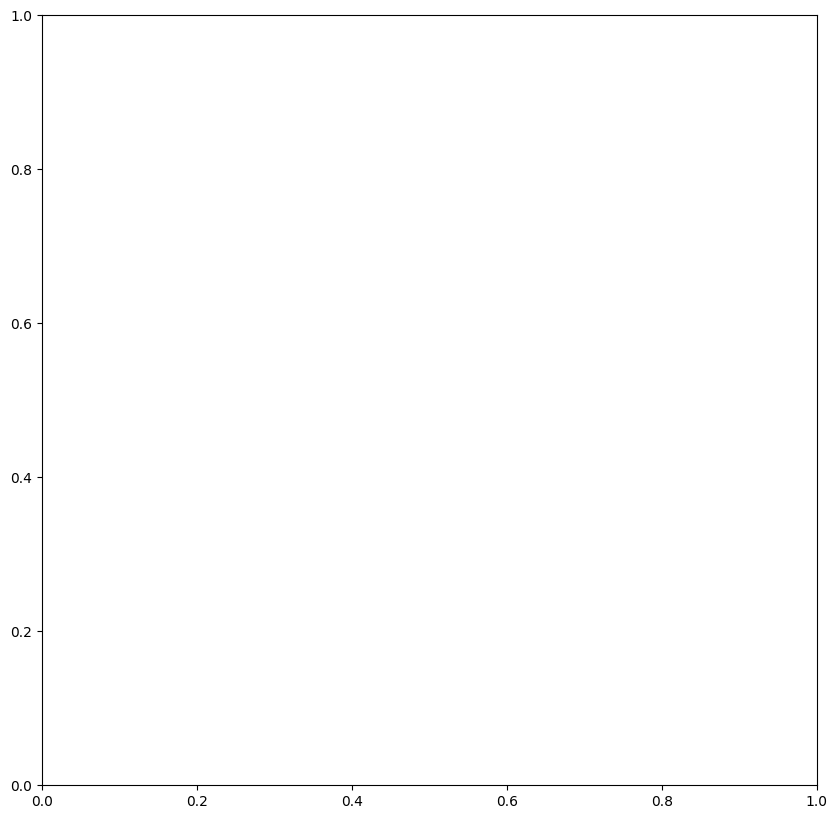

In [1]:
import userinput
import os
import sys
import time
import matplotlib.gridspec as gridspec
import numpy as np
import math
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from model.StefanProblem import stefan_problem, stefan_temperature
from model.ice_depth import locate_ice_ocean_interface
from model.store import create_directory, set_up_matrices, store_results
from model.model_geometry import set_model_geometry
from model.set_time import set_up_iter, t_total
from model.initial_boundary_conditions import set_initial_conditions, boundary_condition
from model.liquid_fraction import update_enthalpy, update_enthalpy_solid_state, update_liquid_fraction
from model.statevariables_errors import reset_error_for_while_loop, compute_error_for_convergence, reset_error_for_while_loop, initialize_statevariables, overwrite_statevariables, set_statevariables, define_previous_statevariable
from model.solve_T_S import AdvectionDiffusion
from calculate_error import error_norms


sys.path.append('Users\sneha\RWTHMSc\Sem2\MBD_Parttime\GitClone_empty\sea-ice-model-buffo\model\info.txt')

#  Set up the model geometry
if userinput.constants == "real":
    from model.constants_real import T_air_Stefan, Tm_w, L, c_i, k_i, rho_i
else:
    from model.constants_debug import T_air_Stefan, Tm_w, L, c_i, k_i, rho_i


class SeaIceModel(error_norms):
    def __init__(self):
        geom = 2
        [self.dz, self.nz, self.Z] = set_model_geometry(geom)
        # Set maximum iteration number, first time step
        self.iter_max = 25000
        dt = userinput.dt
        
        # Define tolerance values for convergence iteration
        self.T_tol = userinput.T_tol
        self.S_tol = userinput.S_tol
        self.phi_tol = userinput.phi_tol

        #dt= 0.5e-5 # 4.8e-7 should be less than tnp1 condition. for the case of unit parameter testing, it should be less than 0.5e-4
        T_IC= userinput.T_IC
        self.S_IC= userinput.S_IC
        P_IC= userinput.P_IC
        self.Stefan = userinput.Stefan
        
        # Initialize
        self.error_temperature, self.error_temperature_sum, self.error_temperature_sum_weighted = np.zeros(self.nz), np.zeros(self.iter_max), np.zeros(self.iter_max)
        self.thickness_index_total, depth_stefan_all = np.zeros(self.iter_max), np.zeros(self.iter_max)
        self.T_Stefan_diff, T_Stefan_prev, self.T_k_diff, T_k_prev = [], np.zeros(self.nz), [], np.zeros(self.nz)
        self.T_Stefan_list, self.T_k_list, self.thickness_list = [], [], []

        [self.iter_max, self.dt, self.t_passed] = set_up_iter(self.iter_max)
        [self.T, self.S, self.phi, self.w] = set_initial_conditions(self.Z, self.nz, T_IC, self.S_IC, P_IC)  # define initial conditons for temperature, brine salinity and liquid fraction
        self.H_solid = update_enthalpy_solid_state(self.S, self.nz)  # compute solid enthalpy
        self.H = update_enthalpy(self.T, self.S, self.phi, self.nz)
        thickness, thickness_index = locate_ice_ocean_interface(self.phi, self.dz, self.nz, Stefan= self.Stefan)
        [all_T, all_S, all_phi, all_H, all_H_solid, all_w, all_thick, all_t_passed]= set_up_matrices(self.iter_max, self.nz)
        [all_T, all_S, all_phi, all_H, all_H_solid, all_w, all_thick, all_t_passed] = \
                store_results(self.T, self.S, self.phi, self.H, self.H_solid, self.w, thickness, self.t_passed, all_T, all_S, all_phi, all_H, all_H_solid, all_w, all_thick,all_t_passed, 0
                        ) 

    def T_running(self,fig, ax1, T_Stefan, T_k ): # script to visualize analytical and numerical solution updates
        ax1.plot(np.linspace(0,self.Z, self.nz), T_k, 'k',label = 'Numerical')
        ax1.plot(np.linspace(0,self.Z, self.nz), T_Stefan, 'r--', label='Analytical')
        ax1.set_xlabel('Depth [non-physical]')
        ax1.set_ylabel('temperature [non-physical]' )
        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)

    def convergence_loop(self, t):
        # set initial values to parameters before loop
        [T_err, S_err, phi_err] = reset_error_for_while_loop(self.T_tol, self.S_tol, self.phi_tol) 
        if t == 1:
            [T_initial , T_km1,  T_prev,S_initial, S_prev, S_km1, phi_initial, phi_prev, phi_km1] = \
            initialize_statevariables(self.T, self.S, self.phi)
        else:
            [T_initial, T_prev,S_initial,  S_prev,phi_initial,  phi_prev] = \
            set_statevariables(T_km1, S_km1, phi_km1)
        T_source = np.zeros(self.nz)
        counter = 0

        # Loop until values converge
        while T_err > self.T_tol: # TODO: or S_err > S_tol or phi_err > phi_tol:
            counter = counter + 1
            if counter > 1 :
                [T_prev, S_prev, phi_prev] = define_previous_statevariable(T_km1, S_km1, phi_km1)

            H_k = update_enthalpy(T_km1, S_km1, phi_km1, self.nz)
            H_solid = update_enthalpy_solid_state( S_km1, self.nz ) 
            phi_k = update_liquid_fraction( T_km1,S_km1, phi_km1, H_k, H_solid, self.nz, Stefan= self.Stefan)   
            thickness, thickness_index = locate_ice_ocean_interface(phi_k, self.dz, self.nz, Stefan = self.Stefan)
            self.thickness_index_total[t] = thickness_index  
            advection_diffusion = AdvectionDiffusion('temperature', T_km1, T_source, T_initial, phi_k, phi_initial, self.w, self.dt, self.dz, self.nz, self.t_passed, self.S_IC, self.Stefan)              
            [T_k , X_wind_T, dt_T] = advection_diffusion.lhs_matrix()
            S_k = S_km1
            [T_km1, S_km1, phi_km1] = overwrite_statevariables(T_k, S_k, phi_k)
            if counter > 0:
                [T_err, T_err_full, S_err, S_err_full, phi_err, phi_err_full] = compute_error_for_convergence(T_k, T_prev, S_k, S_prev, phi_k, phi_prev)
            
        return T_k, T_prev, S_k, S_prev, phi_k, phi_prev, H_k, H_solid, thickness, thickness_index

    def temperature_profile_analytical(self):
        fig1,(ax1) = plt.subplots(1,1, figsize=(10,10))
        all_T, all_S, all_phi, all_H, all_H_solid, all_w , all_thick,all_t_passed = [[] for i in range(8)]

        # loop over x iterations
        for t in range(1,self.iter_max):

            # loop until values converge
            T_k, T_prev, S_k, S_prev, phi_k, phi_prev, H_k, H_solid, thickness, thickness_index = self.convergence_loop(t)

            # computes total time passed
            self.t_passed= t_total(self.t_passed, self.dt)

            # store all results
            [all_T, all_S, all_phi, all_H, all_H_solid, all_w , all_thick,all_t_passed] = \
                store_results( T_k, S_k, phi_k, H_k, H_solid, self.w, thickness, self.t_passed, all_T, all_S, all_phi, all_H, all_H_solid, all_w, all_thick, all_t_passed, t)  
            
            # depth
            depth_stefan_all = stefan_problem(all_t_passed) 
            depth_stefan_t = depth_stefan_all[t]
            T_Stefan = stefan_temperature(depth_stefan_t, self.t_passed, self.dz, self.nz)
            error_depth_t = (np.absolute(depth_stefan_t) - np.absolute(all_thick[t]))
               
            # compute temperature error and store temperature differences
            self.error_temperature[:thickness_index] = np.absolute(np.absolute(T_k[:thickness_index])-np.absolute(T_Stefan[:thickness_index]))
            self.error_temperature_sum[t] = np.sum(self.error_temperature)
            self.error_temperature_sum_weighted[t] = self.error_temperature_sum[t]/thickness_index
            self.T_Stefan_diff.append(T_Stefan - T_Stefan_prev)
            T_Stefan_prev = T_Stefan
            self.T_k_diff.append(T_k - T_k_prev)
            T_k_prev = T_k
            self.T_k_list.append(T_k)
            self.T_Stefan_list.append(T_Stefan)
            self.thickness_list.append(thickness)

            if t%500 == 0:  # plot after every 500 time steps
                self.T_running(fig1, ax1, T_Stefan, T_k)

        self.T_k_list = np.array(self.T_k_list)
        self.T_Stefan_list = np.array(self.T_Stefan_list)
        self.T_k_diff = np.array(self.T_k_diff)
        self.T_Stefan_diff= np.array(self.T_Stefan_diff)

    def error_analytical_numerical(self):
        # Calculates the errors of Numerical and Analytical using error norms one, two and infinity
        # norm(|T_k_list - T_Stefan_list|)
        error_norms.__init__(self.T_k_list, self.T_Stefan_list)
        num_ana_temperature_diff = self.numerical_analytical_diff
        T_k_Stefan_diff_1norm = self.one_norm(num_ana_temperature_diff)
        T_k_Stefan_diff_infnorm = self.infinity_norm(num_ana_temperature_diff)
        T_k_Stefan_diff_2norm = self.two_norm(num_ana_temperature_diff)

        # Calculates the errors of Analytical temperature differences between two consecutive iterations
        # norm(|T_Stefan[i+1] - T_Stefan[i]|)
        T_Stefan_diff_infnorm = self.infinity_norm(self.T_Stefan_diff)   
        T_Stefan_diff_L2norm = self.two_norm(self.T_Stefan_diff)
        T_Stefan_diff_L1norm = self.one_norm(self.T_Stefan_diff)

        # Calculates the errors of Numerical temperature differences between two consecutive iterations
        # norm(|T_k[i+1] - T_k[i]|)
        T_k_diff_infnorm = self.infinity_norm(self.T_k_diff)
        T_k_diff_L2norm = self.two_norm(self.T_k_diff)
        T_k_diff_L1norm = self.one_norm(self.T_k_diff)

if __name__ == "__main__":
    seaicemodel_obj = SeaIceModel()
    seaicemodel_obj.temperature_profile_analytical()